# Multi-Campaign D&D Analysis Tutorial

This notebook demonstrates how to analyze multiple D&D campaigns simultaneously using the extended `dnd_analysis.py` module. We'll load hundreds of campaigns, analyze them both individually and in aggregate, and create comprehensive visualizations.

## Table of Contents
1. [Configuration and Setup](#config)
2. [Loading Multiple Campaigns](#loading)
3. [Campaign Overview](#overview)
4. [Aggregated Analysis](#aggregated)
5. [Paragraph Action Analysis](#paragraph-actions)
6. [Player Campaign Participation Analysis](#participation)
7. [Individual Campaign Analysis](#individual)
8. [Comparative Visualizations](#comparisons)
9. [Multi-Campaign Insights](#insights)

## Configuration and Setup {#config}

**Configure the analysis parameters here:**

In [23]:
# ====================================================
# CONFIGURATION SECTION - MODIFY THESE PARAMETERS
# ====================================================
import os

# Number of campaigns to analyze (None for all, or set a limit for testing)
max_campaigns = 50  # Start with 30 for testing, increase as needed

# Data file path
data_file_path = os.path.join(os.getcwd(), '..','data/raw-human-games/individual_campaigns/')

# Caching settings
use_cache = True  # Set to False to disable caching entirely
force_refresh = False  # Set to True to bypass cache and recompute everything
cache_dir = os.path.join(os.getcwd(), '..','data/processed/campaign_stats_cache')  # Directory for cache files

# Individual campaign to showcase (will be selected from largest campaigns)
showcase_campaign_index = 0  # 0 = largest campaign, 1 = second largest, etc.

# Plot settings
save_plots = True
show_progress = True

print(f"Configuration:")
print(f"  Max campaigns: {max_campaigns if max_campaigns else 'All'}")
print(f"  Data file: {data_file_path}")
print(f"  Use caching: {use_cache}")
print(f"  Force refresh: {force_refresh}")
print(f"  Cache directory: {cache_dir}")
print(f"  Individual showcase: Campaign #{showcase_campaign_index + 1} (by size)")
print(f"  Save plots: {save_plots}")

Configuration:
  Max campaigns: 50
  Data file: /Users/annie/Code/Repositories/dnd-dynamics/tutorials/../data/raw-human-games/individual_campaigns/
  Use caching: True
  Force refresh: False
  Cache directory: /Users/annie/Code/Repositories/dnd-dynamics/tutorials/../data/processed/campaign_stats_cache
  Individual showcase: Campaign #1 (by size)
  Save plots: True


In [24]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sys
from datetime import datetime
warnings.filterwarnings('ignore')
sys.path.append('..')

# Import our analysis modules
import analysis.dnd_analysis as dnd

# Set up plotting style
plt.style.use('default')
sns.set_palette("viridis")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Create Plots directory
if save_plots:
    plots_dir = Path('Plots')
    plots_dir.mkdir(exist_ok=True)
    print(f"Plots will be saved to: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    if save_plots:
        filepath = plots_dir / filename
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Saved: {filepath}")

print("Libraries imported successfully!")
print("Ready to analyze multiple D&D campaigns!")

Plots will be saved to: Plots
Libraries imported successfully!
Ready to analyze multiple D&D campaigns!


## Loading Multiple Campaigns {#loading}

**Intelligent Caching System**: This notebook uses smart incremental computation to speed up analysis. It will automatically:
- Use exact cached results if available
- Load the largest cached result and compute only additional campaigns needed
- Save results for future use

The caching system tracks data file changes and ensures results stay fresh.

In [25]:
# Check cache status before starting
print("=== CACHE STATUS ===")
if use_cache:
    dnd.show_cache_status(cache_dir)
    
    # Show available cached results
    available_caches = dnd.get_available_cached_results(cache_dir)
    if available_caches:
        print(f"\n🎯 Analysis target: {max_campaigns} campaigns")
        
        # Find best cache match for incremental computation
        suitable_caches = [cache for cache in available_caches if cache['num_campaigns'] <= max_campaigns]
        if suitable_caches:
            best_cache = suitable_caches[-1]  # Largest suitable cache
            if best_cache['num_campaigns'] == max_campaigns:
                print(f"✅ Exact cache match found!")
            else:
                additional_needed = max_campaigns - best_cache['num_campaigns']
                print(f"📁 Will use cache for {best_cache['num_campaigns']} campaigns")
                print(f"⚡ Need to compute {additional_needed} additional campaigns")
        else:
            print(f"📊 No suitable cache found - will run fresh analysis")
    else:
        print(f"📊 No cached results found - will run fresh analysis")
else:
    print("⚠️  Caching disabled - will run fresh analysis")

=== CACHE STATUS ===
📊 CACHED ANALYSIS RESULTS (2 files)
Cache directory: /Users/annie/Code/Repositories/dnd-dynamics/tutorials/../data/processed/campaign_stats_cache

  📁 campaign_analysis_40_campaigns.pkl
     Campaigns: 40
     Messages: 45,839
     Created: 2025-07-16T12:47:18
     Size: 12.71 MB

  📁 campaign_analysis_985_campaigns.pkl
     Campaigns: 985
     Messages: 949,596
     Created: 2025-06-26T17:51:57
     Size: 205.97 MB

Total cache size: 218.68 MB

🎯 Analysis target: 50 campaigns
📁 Will use cache for 40 campaigns
⚡ Need to compute 10 additional campaigns


In [26]:
# Smart campaign loading with caching
print("\n=== LOADING/COMPUTING CAMPAIGN ANALYSIS ===")
start_time = datetime.now()

try:
    if use_cache:
        # Use intelligent incremental loading
        all_results = dnd.load_or_compute_incremental(
            max_campaigns=max_campaigns,
            data_file_path=data_file_path,
            cache_dir=cache_dir,
            force_refresh=force_refresh,
            show_progress=show_progress
        )
        
        # Extract results components
        aggregated = all_results['aggregated']
        summary_stats = all_results['summary_stats']
        
        # For compatibility, we need campaign_dataframes for some visualizations
        # We'll reconstruct them by loading the campaigns again (this could be optimized)
        campaign_dataframes = dnd.load_all_campaigns(
            json_file_path=data_file_path,
            max_campaigns=max_campaigns,
            show_progress=False
        )
        
    else:
        # Traditional loading without caching
        print("🔄 Loading campaigns without caching...")
        campaign_dataframes, json_data = dnd.load_all_campaigns(
            json_file_path=data_file_path,
            max_campaigns=max_campaigns,
            show_progress=show_progress,
            return_json=True
        )
        
        if not campaign_dataframes:
            raise ValueError("Failed to load campaigns")
        
        print("🔄 Running analysis...")
        all_results = dnd.analyze_all_campaigns(
            campaign_dataframes=campaign_dataframes,
            original_json_data=json_data,
            show_progress=show_progress
        )
        
        # Extract results components
        aggregated = all_results['aggregated']
        summary_stats = all_results['summary_stats']
    
    total_time = datetime.now() - start_time
    print(f"\n✅ Analysis completed in {total_time}")
    
    # Show final statistics
    if summary_stats:
        print(f"\n📊 FINAL RESULTS:")
        print(f"  Campaigns analyzed: {summary_stats['total_campaigns']}")
        print(f"  Total messages: {summary_stats['total_messages']:,}")
        
        if campaign_dataframes:
            avg_campaign_size = summary_stats['total_messages'] / len(campaign_dataframes)
            print(f"  Average messages per campaign: {avg_campaign_size:.1f}")
    
except Exception as e:
    print(f"❌ Error during analysis: {e}")
    print("Please check the data file path and configuration.")
    campaign_dataframes = {}
    aggregated = {}
    summary_stats = {}
    all_results = {}
    import traceback
    traceback.print_exc()


=== LOADING/COMPUTING CAMPAIGN ANALYSIS ===
🎯 Target: Analysis of 50 campaigns
📁 Found cached results for 40 campaigns
🔄 Computing additional 10 campaigns (41-50)...
📁 Loaded cache: campaign_analysis_40_campaigns.pkl (created: 2025-07-16T12:47:18, 12.71 MB)
⚡ Processing 10 additional campaigns...
Analyzing 10 campaigns...


Analyzing campaigns: 100%|██████████| 10/10 [00:00<00:00, 21.01it/s]


Generating aggregated statistics...
🔄 Merging cached and new results...
🔄 Re-aggregating combined results...
💾 Saved cache: campaign_analysis_50_campaigns.pkl (14.07 MB)
✅ Incremental analysis complete: 50 campaigns total

✅ Analysis completed in 0:00:21.999450

📊 FINAL RESULTS:
  Campaigns analyzed: 50
  Total messages: 53,064
  Average messages per campaign: 1061.3


=== CAMPAIGN OVERVIEW ===

📈 Top 15 Largest Campaigns:
   1. 12007-the-glory-of-the-coliseum-always-recruiting: 9,264 messages
   2. 13325-lost-magics-epic-of-pre-made-proportions: 4,189 messages
   3. 12878-eon-survival-at-sea: 3,214 messages
   4. 13340-temple-of-ishassara: 3,138 messages
   5. 11146-tomb-of-annihilation-4pbp: 2,954 messages
   6. 13844-lost-mine-of-phandelver-kolbitr-dm: 2,567 messages
   7. 10639-the-crypt-of-the-dreaming-dead: 2,162 messages
   8. 12528-tieflings-of-annihilation: 1,575 messages
   9. 10672-whispers-of-dissent: 1,542 messages
  10. 13483-princes-of-the-apocalypse: 1,378 messages
  11. 13513-storm-kings-thunder: 1,088 messages
  12. 12089-the-tavern-casual-rp-socializing: 1,085 messages
  13. 13174-dragon-of-autumn-icc: 1,046 messages
  14. 14191-high-times-at-low-tides: 958 messages
  15. 12296-atriaxs-return: 939 messages

🎯 Selected for individual analysis: 12007-the-glory-of-the-coliseum-always-recruiting
   Size: 9,264 messages
Saved: Plots/cam

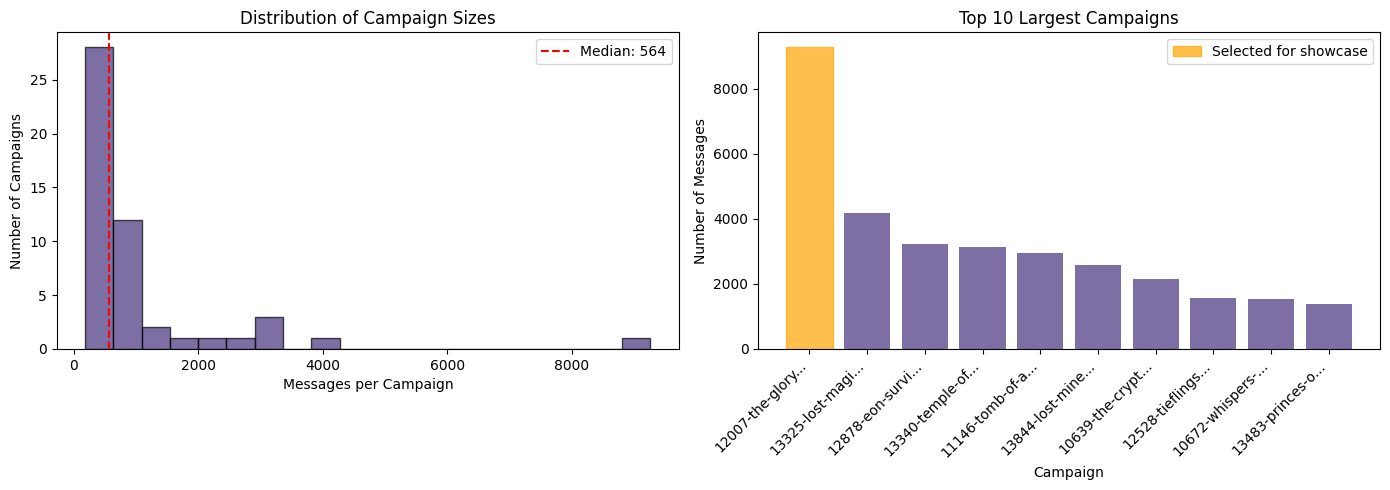

In [34]:
# Campaign overview and showcase selection
if campaign_dataframes:
    print("=== CAMPAIGN OVERVIEW ===")
    
    # List campaigns by size
    campaigns_by_size = dnd.list_campaigns_by_size(campaign_dataframes, top_n=15)
    
    print(f"\n📈 Top 15 Largest Campaigns:")
    for i, (campaign_id, message_count) in enumerate(campaigns_by_size, 1):
        print(f"  {i:2d}. {campaign_id[:50]}{'...' if len(campaign_id) > 50 else ''}: {message_count:,} messages")
    
    # Select campaign for individual showcase
    if len(campaigns_by_size) > showcase_campaign_index:
        showcase_campaign_id = campaigns_by_size[showcase_campaign_index][0]
        showcase_campaign_size = campaigns_by_size[showcase_campaign_index][1]
        print(f"\n🎯 Selected for individual analysis: {showcase_campaign_id}")
        print(f"   Size: {showcase_campaign_size:,} messages")
    else:
        showcase_campaign_id = None
        print(f"\n⚠️  Not enough campaigns loaded for showcase index {showcase_campaign_index}")
    
    # Basic statistics visualization
    campaign_sizes = [size for _, size in campaigns_by_size]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Campaign sizes distribution
    all_sizes = [len(df) for df in campaign_dataframes.values()]
    ax1.hist(all_sizes, bins=min(20, len(all_sizes)//2), alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Messages per Campaign')
    ax1.set_ylabel('Number of Campaigns')
    ax1.set_title('Distribution of Campaign Sizes')
    ax1.axvline(np.median(all_sizes), color='red', linestyle='--', 
                label=f'Median: {np.median(all_sizes):.0f}')
    ax1.legend()
    
    # Top campaigns bar chart
    top_10_campaigns = campaigns_by_size[:10]
    top_names = [cid[:15] + '...' if len(cid) > 15 else cid for cid, _ in top_10_campaigns]
    top_sizes = [size for _, size in top_10_campaigns]
    
    bars = ax2.bar(range(len(top_sizes)), top_sizes, alpha=0.7)
    ax2.set_xlabel('Campaign')
    ax2.set_ylabel('Number of Messages')
    ax2.set_title('Top 10 Largest Campaigns')
    ax2.set_xticks(range(len(top_names)))
    ax2.set_xticklabels(top_names, rotation=45, ha='right')
    
    # Highlight showcase campaign
    if showcase_campaign_index < len(bars):
        bars[showcase_campaign_index].set_color('orange')
        bars[showcase_campaign_index].set_label('Selected for showcase')
        ax2.legend()
    
    plt.tight_layout()
    save_plot('campaign_overview.png')
    plt.show()
    
else:
    print("No campaigns loaded. Please check the loading section above.")

## Aggregated Analysis {#aggregated}

The analysis has been completed using the intelligent caching system. Results are now available for visualization and insights.

In [35]:
# Display aggregated results overview
if summary_stats and aggregated:
    print("=== ANALYSIS RESULTS OVERVIEW ===")
    print(f"  Campaigns analyzed: {summary_stats['total_campaigns']}")
    print(f"  Total messages: {summary_stats['total_messages']:,}")
    print(f"  Aggregated metrics available: {list(aggregated.keys())}")
    
    # Check if paragraph actions analysis is available
    if 'paragraph_actions' in aggregated:
        para_actions = aggregated['paragraph_actions']
        print(f"  📋 Paragraph actions analysis: Available ({para_actions['campaigns_analyzed']} campaigns)")
        print(f"     Total paragraphs analyzed: {para_actions['total_paragraphs']:,}")
    else:
        print(f"  📋 Paragraph actions analysis: Not available (requires JSON data)")
    
    print(f"  Analysis completed successfully using smart caching system!")
else:
    print("❌ No analysis results available. Please check the loading section.")
    aggregated = {}
    summary_stats = {}
    all_results = {}

=== ANALYSIS RESULTS OVERVIEW ===
  Campaigns analyzed: 50
  Total messages: 53,064
  Aggregated metrics available: ['time_intervals', 'post_lengths', 'message_types', 'dice_rolls', 'character_mentions', 'paragraph_actions']
  📋 Paragraph actions analysis: Available (50 campaigns)
     Total paragraphs analyzed: 120,315
  Analysis completed successfully using smart caching system!


In [36]:
# Multi-campaign summary statistics
if summary_stats:
    print("=== MULTI-CAMPAIGN SUMMARY STATISTICS ===")
    
    print(f"\n🏢 CAMPAIGN SIZE DISTRIBUTION")
    size_stats = summary_stats['campaign_size_stats']
    print(f"  Mean messages per campaign: {size_stats['mean_messages']:.1f}")
    print(f"  Median messages per campaign: {size_stats['median_messages']:.1f}")
    print(f"  Range: {size_stats['min_messages']:.0f} - {size_stats['max_messages']:.0f} messages")
    print(f"  Standard deviation: {size_stats['std_messages']:.1f}")
    
    print(f"\n📅 CAMPAIGN DURATION DISTRIBUTION")
    duration_stats = summary_stats['duration_stats']
    print(f"  Mean duration: {duration_stats['mean_days']:.1f} days")
    print(f"  Median duration: {duration_stats['median_days']:.1f} days")
    print(f"  Range: {duration_stats['min_days']:.0f} - {duration_stats['max_days']:.0f} days")
    print(f"  Standard deviation: {duration_stats['std_days']:.1f} days")
    
    print(f"\n👥 PLAYER COUNT DISTRIBUTION")
    player_stats = summary_stats['player_count_stats']
    print(f"  Mean players per campaign: {player_stats['mean_players']:.1f}")
    print(f"  Median players per campaign: {player_stats['median_players']:.1f}")
    print(f"  Range: {player_stats['min_players']:.0f} - {player_stats['max_players']:.0f} players")
    print(f"  Standard deviation: {player_stats['std_players']:.1f}")
    
    print(f"\n⚡ ACTIVITY LEVEL DISTRIBUTION")
    activity_stats = summary_stats['activity_stats']
    print(f"  Mean posts per day: {activity_stats['mean_posts_per_day']:.2f}")
    print(f"  Median posts per day: {activity_stats['median_posts_per_day']:.2f}")
    print(f"  Range: {activity_stats['min_posts_per_day']:.2f} - {activity_stats['max_posts_per_day']:.2f} posts/day")
    print(f"  Standard deviation: {activity_stats['std_posts_per_day']:.2f}")

=== MULTI-CAMPAIGN SUMMARY STATISTICS ===

🏢 CAMPAIGN SIZE DISTRIBUTION
  Mean messages per campaign: 722.5
  Median messages per campaign: 515.5
  Range: 217 - 2567 messages
  Standard deviation: 676.4

📅 CAMPAIGN DURATION DISTRIBUTION
  Mean duration: 139.9 days
  Median duration: 76.0 days
  Range: 23 - 668 days
  Standard deviation: 183.3 days

👥 PLAYER COUNT DISTRIBUTION
  Mean players per campaign: 7.3
  Median players per campaign: 7.0
  Range: 4 - 12 players
  Standard deviation: 2.0

⚡ ACTIVITY LEVEL DISTRIBUTION
  Mean posts per day: 8.03
  Median posts per day: 4.67
  Range: 2.64 - 21.35 posts/day
  Standard deviation: 6.10


In [37]:
# Aggregated gameplay metrics
if aggregated:
    print("\n=== AGGREGATED GAMEPLAY METRICS ===")
    
    # Time intervals
    if 'time_intervals' in aggregated:
        intervals = aggregated['time_intervals']
        print(f"\n⏰ POSTING INTERVALS (Combined across all campaigns)")
        print(f"  Mean time between posts: {intervals['mean_hours']:.2f} hours")
        print(f"  Median time between posts: {intervals['median_hours']:.2f} hours")
        print(f"  Total intervals analyzed: {intervals['count']:,}")
    
    # Post lengths
    if 'post_lengths' in aggregated:
        lengths = aggregated['post_lengths']
        print(f"\n📝 POST LENGTHS (Combined across all campaigns)")
        print(f"  Mean words per post: {lengths['mean_words']:.1f}")
        print(f"  Median words per post: {lengths['median_words']:.1f}")
        print(f"  Longest post: {lengths['max_words']:.0f} words")
        print(f"  Total posts analyzed: {lengths['count']:,}")
    
    # Message types
    if 'message_types' in aggregated:
        types = aggregated['message_types']
        print(f"\n🎭 MESSAGE TYPES (Combined across all campaigns)")
        print(f"  Action posts: {types['action_posts']:,} ({types['action_percentage']:.1f}%)")
        print(f"  Dialogue posts: {types['dialogue_posts']:,} ({types['dialogue_percentage']:.1f}%)")
        print(f"  Narrative posts: {types['narrative_posts']:,} ({types['narrative_percentage']:.1f}%)")
        print(f"  Total posts: {types['total_posts']:,}")
    
    # Dice rolls
    if 'dice_rolls' in aggregated:
        dice = aggregated['dice_rolls']
        print(f"\n🎲 DICE ROLL FREQUENCY (Combined across all campaigns)")
        print(f"  Posts with dice rolls: {dice['posts_with_rolls']:,} ({dice['roll_percentage']:.1f}%)")
        print(f"  Posts without dice rolls: {dice['posts_without_rolls']:,}")
        print(f"  Total posts: {dice['total_posts']:,}")
    
    # Character mentions
    if 'character_mentions' in aggregated:
        mentions = aggregated['character_mentions']
        print(f"\n👥 CHARACTER MENTIONS (Combined across all campaigns)")
        if mentions['total_mentions'] > 0:
            print(f"  Total character mentions: {mentions['total_mentions']:,}")
            print(f"  Unique characters mentioned: {mentions['unique_characters_mentioned']:,}")
            print(f"  Top 5 most mentioned characters:")
            for i, (char, count) in enumerate(list(mentions['top_mentions'].items())[:5], 1):
                print(f"    {i}. {char}: {count:,} mentions")
        else:
            print(f"  No character mentions found in this dataset")
            print(f"  (This is expected for some datasets that don't track character mentions)")


=== AGGREGATED GAMEPLAY METRICS ===

⏰ POSTING INTERVALS (Combined across all campaigns)
  Mean time between posts: 1.75 hours
  Median time between posts: 0.32 hours
  Total intervals analyzed: 51,844

📝 POST LENGTHS (Combined across all campaigns)
  Mean words per post: 42.3
  Median words per post: 30.0
  Longest post: 200 words
  Total posts analyzed: 50,944

🎭 MESSAGE TYPES (Combined across all campaigns)
  Action posts: 21,797 (41.1%)
  Dialogue posts: 14,832 (28.0%)
  Narrative posts: 16,435 (31.0%)
  Total posts: 53,064

🎲 DICE ROLL FREQUENCY (Combined across all campaigns)
  Posts with dice rolls: 4,469 (8.4%)
  Posts without dice rolls: 48,595
  Total posts: 53,064

👥 CHARACTER MENTIONS (Combined across all campaigns)
  No character mentions found in this dataset
  (This is expected for some datasets that don't track character mentions)


## Paragraph Action Analysis {#paragraph-actions}

This section analyzes action types at the paragraph level across all campaigns. This provides more granular insights into what types of actions players are taking and how they label their content (in-character vs out-of-character).


=== PARAGRAPH-LEVEL ACTION ANALYSIS ===

📋 PARAGRAPH ACTION TYPES (Across 50 campaigns with JSON data)
  Total paragraphs analyzed: 120,315
  Name mentions: 56,646 (47.1%)
  Spells: 5,017 (4.2%)
  Dialogue: 31,898 (26.5%)
  Dice rolls: 14,879 (12.4%)
  Weapons: 3,463 (2.9%)
  No action: 40,895 (34.0%)

🎭 CHARACTER LABELS (Paragraph level)
  In-character: 58,148 (48.3%)
  Out-of-character: 43,238 (35.9%)
  Mixed: 3,889 (3.2%)
  Unlabeled: 15,040 (12.5%)
Saved: Plots/multi_campaign_paragraph_actions.png


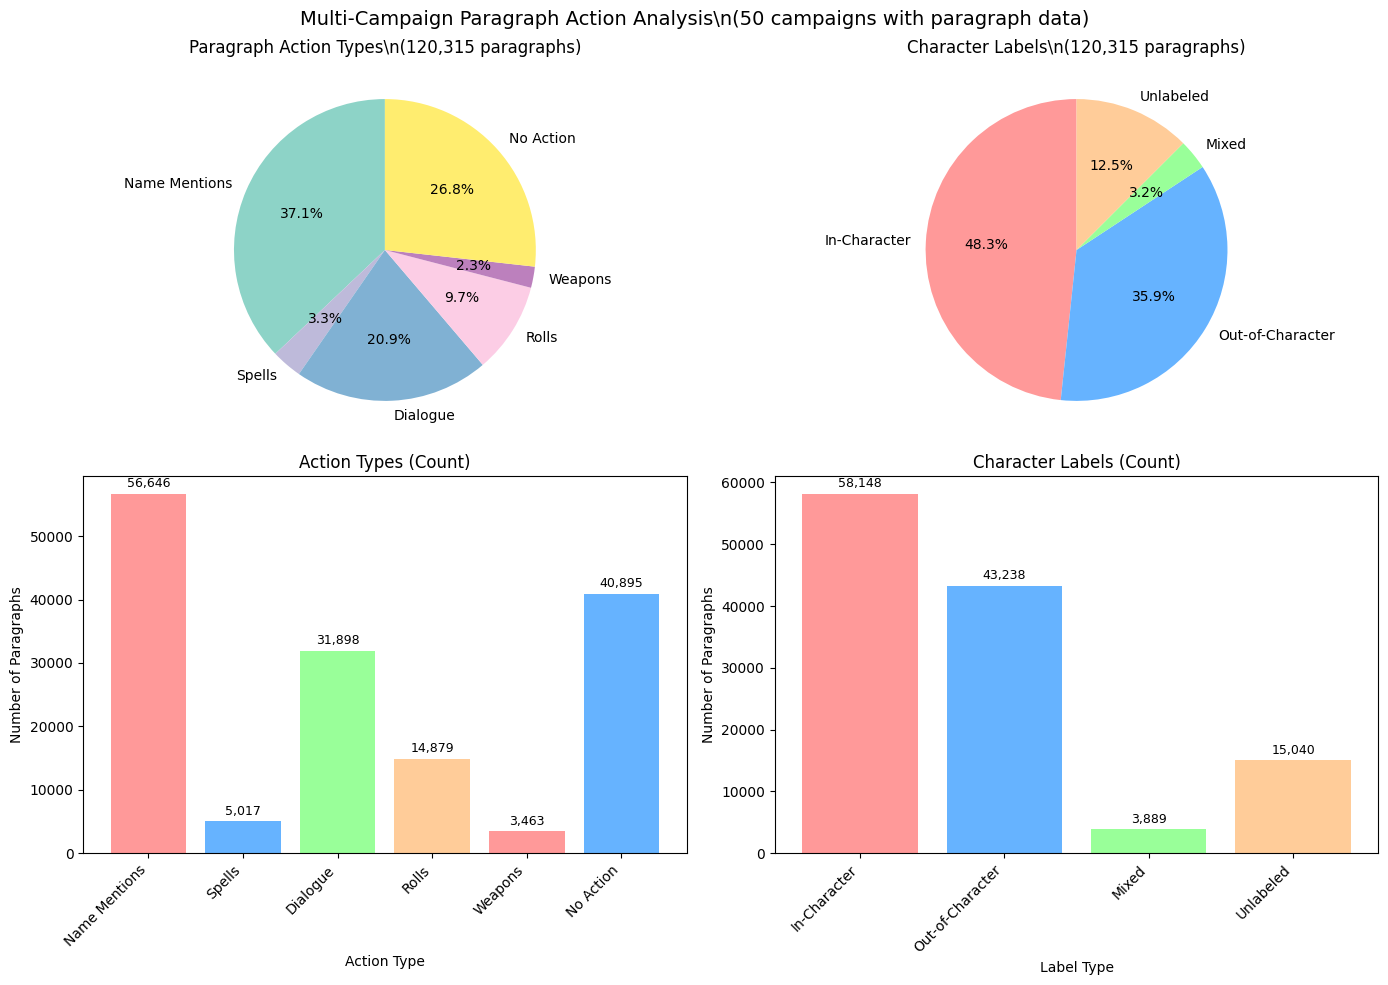

\n✅ Paragraph action analysis visualization created!


In [38]:
# Paragraph-level Action Analysis (New Feature)
if aggregated and 'paragraph_actions' in aggregated:
    print("\n=== PARAGRAPH-LEVEL ACTION ANALYSIS ===")
    
    para_actions = aggregated['paragraph_actions']
    total_paras = para_actions['total_paragraphs']
    campaigns_analyzed = para_actions['campaigns_analyzed']
    
    print(f"\n📋 PARAGRAPH ACTION TYPES (Across {campaigns_analyzed} campaigns with JSON data)")
    print(f"  Total paragraphs analyzed: {total_paras:,}")
    print(f"  Name mentions: {para_actions['name_mentions_paragraphs']:,} ({para_actions['name_mentions_percentage']:.1f}%)")
    print(f"  Spells: {para_actions['spells_paragraphs']:,} ({para_actions['spells_percentage']:.1f}%)")
    print(f"  Dialogue: {para_actions['dialogue_paragraphs']:,} ({para_actions['dialogue_percentage']:.1f}%)")
    print(f"  Dice rolls: {para_actions['roll_paragraphs']:,} ({para_actions['roll_percentage']:.1f}%)")
    print(f"  Weapons: {para_actions['weapon_paragraphs']:,} ({para_actions['weapon_percentage']:.1f}%)")
    print(f"  No action: {para_actions['no_action_paragraphs']:,} ({para_actions['no_action_percentage']:.1f}%)")
    
    print(f"\n🎭 CHARACTER LABELS (Paragraph level)")
    print(f"  In-character: {para_actions['in_character_paragraphs']:,} ({para_actions['in_character_percentage']:.1f}%)")
    print(f"  Out-of-character: {para_actions['out_of_character_paragraphs']:,} ({para_actions['out_of_character_percentage']:.1f}%)")
    print(f"  Mixed: {para_actions['mixed_paragraphs']:,} ({para_actions['mixed_percentage']:.1f}%)")
    print(f"  Unlabeled: {para_actions['unlabeled_paragraphs']:,} ({para_actions['unlabeled_percentage']:.1f}%)")
    
    # Create comprehensive paragraph actions visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Action types pie chart
    action_labels = ['Name Mentions', 'Spells', 'Dialogue', 'Rolls', 'Weapons', 'No Action']
    action_counts = [
        para_actions['name_mentions_paragraphs'],
        para_actions['spells_paragraphs'], 
        para_actions['dialogue_paragraphs'],
        para_actions['roll_paragraphs'],
        para_actions['weapon_paragraphs'],
        para_actions['no_action_paragraphs']
    ]
    
    # Only include non-zero categories
    non_zero_actions = [(label, count) for label, count in zip(action_labels, action_counts) if count > 0]
    if non_zero_actions:
        labels, counts = zip(*non_zero_actions)
        colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
        wedges, texts, autotexts = ax1.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax1.set_title(f'Paragraph Action Types\\n({total_paras:,} paragraphs)')
    
    # 2. Character labels pie chart  
    label_labels = ['In-Character', 'Out-of-Character', 'Mixed', 'Unlabeled']
    label_counts = [
        para_actions['in_character_paragraphs'],
        para_actions['out_of_character_paragraphs'],
        para_actions['mixed_paragraphs'], 
        para_actions['unlabeled_paragraphs']
    ]
    
    non_zero_labels = [(label, count) for label, count in zip(label_labels, label_counts) if count > 0]
    if non_zero_labels:
        l_labels, l_counts = zip(*non_zero_labels)
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][:len(l_labels)]
        ax2.pie(l_counts, labels=l_labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax2.set_title(f'Character Labels\\n({total_paras:,} paragraphs)')
    
    # 3. Action types bar chart
    if non_zero_actions:
        labels, counts = zip(*non_zero_actions)
        bars = ax3.bar(range(len(labels)), counts, color=colors)
        ax3.set_title('Action Types (Count)')
        ax3.set_xlabel('Action Type')
        ax3.set_ylabel('Number of Paragraphs')
        ax3.set_xticks(range(len(labels)))
        ax3.set_xticklabels(labels, rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, value in zip(bars, counts):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
    
    # 4. Character labels bar chart
    if non_zero_labels:
        l_labels, l_counts = zip(*non_zero_labels)
        bars = ax4.bar(range(len(l_labels)), l_counts, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'][:len(l_labels)])
        ax4.set_title('Character Labels (Count)')
        ax4.set_xlabel('Label Type')
        ax4.set_ylabel('Number of Paragraphs')
        ax4.set_xticks(range(len(l_labels)))
        ax4.set_xticklabels(l_labels, rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, value in zip(bars, l_counts):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(l_counts)*0.01,
                    f'{value:,}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle(f'Multi-Campaign Paragraph Action Analysis\\n({campaigns_analyzed} campaigns with paragraph data)', fontsize=14)
    plt.tight_layout()
    save_plot('multi_campaign_paragraph_actions.png')
    plt.show()
    
    print(f"\\n✅ Paragraph action analysis visualization created!")
    
elif aggregated:
    print("\\n⚠️  Paragraph action analysis not available")
    print("This analysis requires campaigns with paragraph-level action data.")
    print("Available aggregated metrics:", list(aggregated.keys()))
else:
    print("\\n❌ No aggregated analysis results available.")


=== CREATING AGGREGATED VISUALIZATIONS ===
Saved: Plots/multi_campaign_dashboard.png


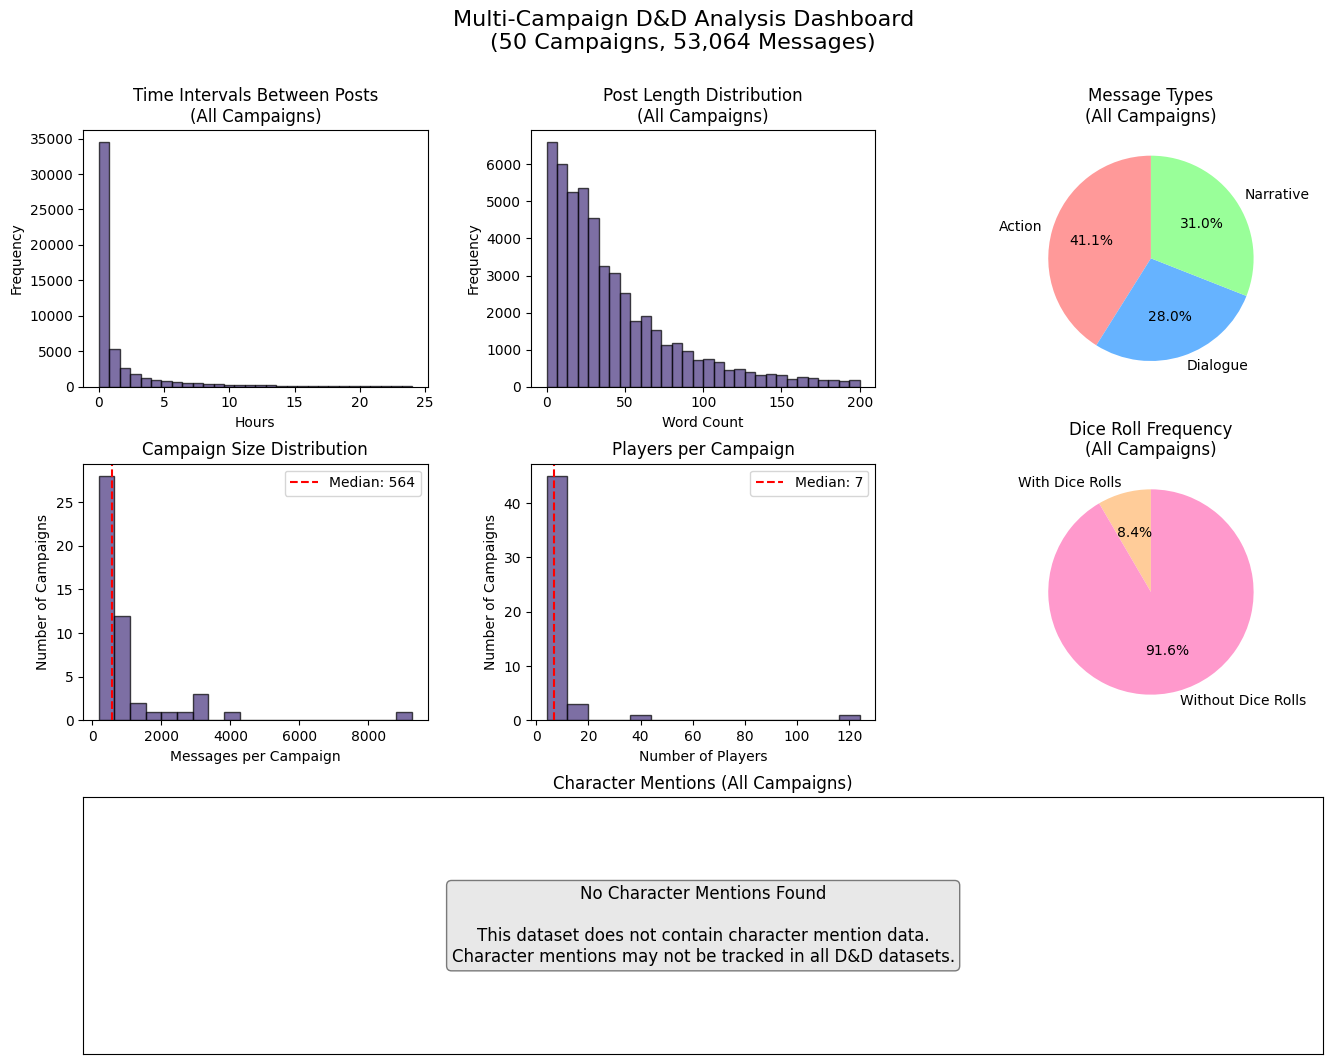

✅ Multi-campaign dashboard created!


In [39]:
# Create aggregated visualizations (equivalent to tutorial.ipynb but for all campaigns)
if aggregated:
    print("\n=== CREATING AGGREGATED VISUALIZATIONS ===")
    
    # Create comprehensive multi-campaign dashboard
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Time intervals distribution (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    if 'time_intervals' in aggregated:
        intervals_data = aggregated['time_intervals']['intervals_data']
        # Limit to reasonable range for visualization
        intervals_plot = intervals_data[intervals_data <= 24]
        ax1.hist(intervals_plot, bins=30, alpha=0.7, edgecolor='black')
        ax1.set_title('Time Intervals Between Posts\n(All Campaigns)')
        ax1.set_xlabel('Hours')
        ax1.set_ylabel('Frequency')
    
    # 2. Post length distribution (top center)
    ax2 = fig.add_subplot(gs[0, 1])
    if 'post_lengths' in aggregated:
        lengths_data = aggregated['post_lengths']['word_counts_data']
        # Limit to reasonable range for visualization
        lengths_plot = lengths_data[lengths_data <= 200]
        ax2.hist(lengths_plot, bins=30, alpha=0.7, edgecolor='black')
        ax2.set_title('Post Length Distribution\n(All Campaigns)')
        ax2.set_xlabel('Word Count')
        ax2.set_ylabel('Frequency')
    
    # 3. Message types pie chart (top right)
    ax3 = fig.add_subplot(gs[0, 2])
    if 'message_types' in aggregated:
        types = aggregated['message_types']
        labels = ['Action', 'Dialogue', 'Narrative']
        sizes = [types['action_posts'], types['dialogue_posts'], types['narrative_posts']]
        colors = ['#ff9999', '#66b3ff', '#99ff99']
        ax3.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax3.set_title('Message Types\n(All Campaigns)')
    
    # 4. Campaign size distribution (middle left)
    ax4 = fig.add_subplot(gs[1, 0])
    if summary_stats:
        campaign_sizes = [len(df) for df in campaign_dataframes.values()]
        ax4.hist(campaign_sizes, bins=min(20, len(campaign_sizes)//2), alpha=0.7, edgecolor='black')
        ax4.set_title('Campaign Size Distribution')
        ax4.set_xlabel('Messages per Campaign')
        ax4.set_ylabel('Number of Campaigns')
        ax4.axvline(np.median(campaign_sizes), color='red', linestyle='--', 
                    label=f'Median: {np.median(campaign_sizes):.0f}')
        ax4.legend()
    
    # 5. Player count distribution (middle center)
    ax5 = fig.add_subplot(gs[1, 1])
    if summary_stats:
        player_counts = [df['player'].nunique() for df in campaign_dataframes.values()]
        ax5.hist(player_counts, bins=min(15, max(player_counts)), alpha=0.7, edgecolor='black')
        ax5.set_title('Players per Campaign')
        ax5.set_xlabel('Number of Players')
        ax5.set_ylabel('Number of Campaigns')
        ax5.axvline(np.median(player_counts), color='red', linestyle='--',
                    label=f'Median: {np.median(player_counts):.0f}')
        ax5.legend()
    
    # 6. Dice roll frequency (middle right)
    ax6 = fig.add_subplot(gs[1, 2])
    if 'dice_rolls' in aggregated:
        dice = aggregated['dice_rolls']
        labels = ['With Dice Rolls', 'Without Dice Rolls']
        sizes = [dice['posts_with_rolls'], dice['posts_without_rolls']]
        colors = ['#ffcc99', '#ff99cc']
        ax6.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax6.set_title('Dice Roll Frequency\n(All Campaigns)')
    
    # 7. Top character mentions (bottom)
    ax7 = fig.add_subplot(gs[2, :])
    if 'character_mentions' in aggregated:
        mentions = aggregated['character_mentions']
        
        # Check if there are any character mentions to display
        if mentions['total_mentions'] > 0:
            top_chars = mentions['top_mentions_names'][:15]
            top_counts = mentions['top_mentions_counts'][:15]
            
            bars = ax7.bar(range(len(top_chars)), top_counts, alpha=0.7)
            ax7.set_title('Top 15 Most Mentioned Characters (All Campaigns)')
            ax7.set_xlabel('Character Name')
            ax7.set_ylabel('Total Mentions')
            ax7.set_xticks(range(len(top_chars)))
            ax7.set_xticklabels([char[:15] + '...' if len(char) > 15 else char for char in top_chars], 
                               rotation=45, ha='right')
            
            # Add value labels on bars
            for bar, value in zip(bars, top_counts):
                ax7.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(top_counts)*0.01,
                        f'{value:,}', ha='center', va='bottom', fontsize=8)
        else:
            # No character mentions found - display message
            ax7.text(0.5, 0.5, 'No Character Mentions Found\n\n' +
                     'This dataset does not contain character mention data.\n' +
                     'Character mentions may not be tracked in all D&D datasets.',
                     ha='center', va='center', transform=ax7.transAxes, 
                     fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
            ax7.set_title('Character Mentions (All Campaigns)')
            ax7.set_xlim(0, 1)
            ax7.set_ylim(0, 1)
            ax7.set_xticks([])
            ax7.set_yticks([])
    
    plt.suptitle(f'Multi-Campaign D&D Analysis Dashboard\n({len(campaign_dataframes)} Campaigns, {summary_stats.get("total_messages", 0):,} Messages)', 
                 fontsize=16, y=0.98)
    save_plot('multi_campaign_dashboard.png')
    plt.show()
    
    print("✅ Multi-campaign dashboard created!")
else:
    print("No aggregated data available for visualization.")

## Player Campaign Participation Analysis {#participation}

Analyze how many campaigns each player has participated in across the dataset to understand player engagement patterns and community overlap.

=== PLAYER CAMPAIGN PARTICIPATION ANALYSIS ===

📊 PARTICIPATION OVERVIEW
  Total unique players: 318
  Average campaigns per player: 1.64
  Median campaigns per player: 1.0
  Most active player: 8 campaigns
  Players in only 1 campaign: 225 (70.8%)

📈 PARTICIPATION DISTRIBUTION
  8 campaigns: 1 players (0.3%)
  7 campaigns: 4 players (1.3%)
  6 campaigns: 3 players (0.9%)
  5 campaigns: 9 players (2.8%)
  4 campaigns: 12 players (3.8%)
  3 campaigns: 21 players (6.6%)
  2 campaigns: 43 players (13.5%)
  1 campaigns: 225 players (70.8%)

🏆 MOST ACTIVE PLAYERS (Top 10)
   1. FrandalSilvereyes: 8 campaigns
   2. AmazingAmazon: 7 campaigns
   3. BirdCopp: 7 campaigns
   4. Necmo: 7 campaigns
   5. jimmop: 7 campaigns
   6. NeoMagus: 6 campaigns
   7. TheG111: 6 campaigns
   8. VanderLegion: 6 campaigns
   9. AfroSamurai: 5 campaigns
  10. DirtyDogP: 5 campaigns
Saved: Plots/player_campaign_participation.png


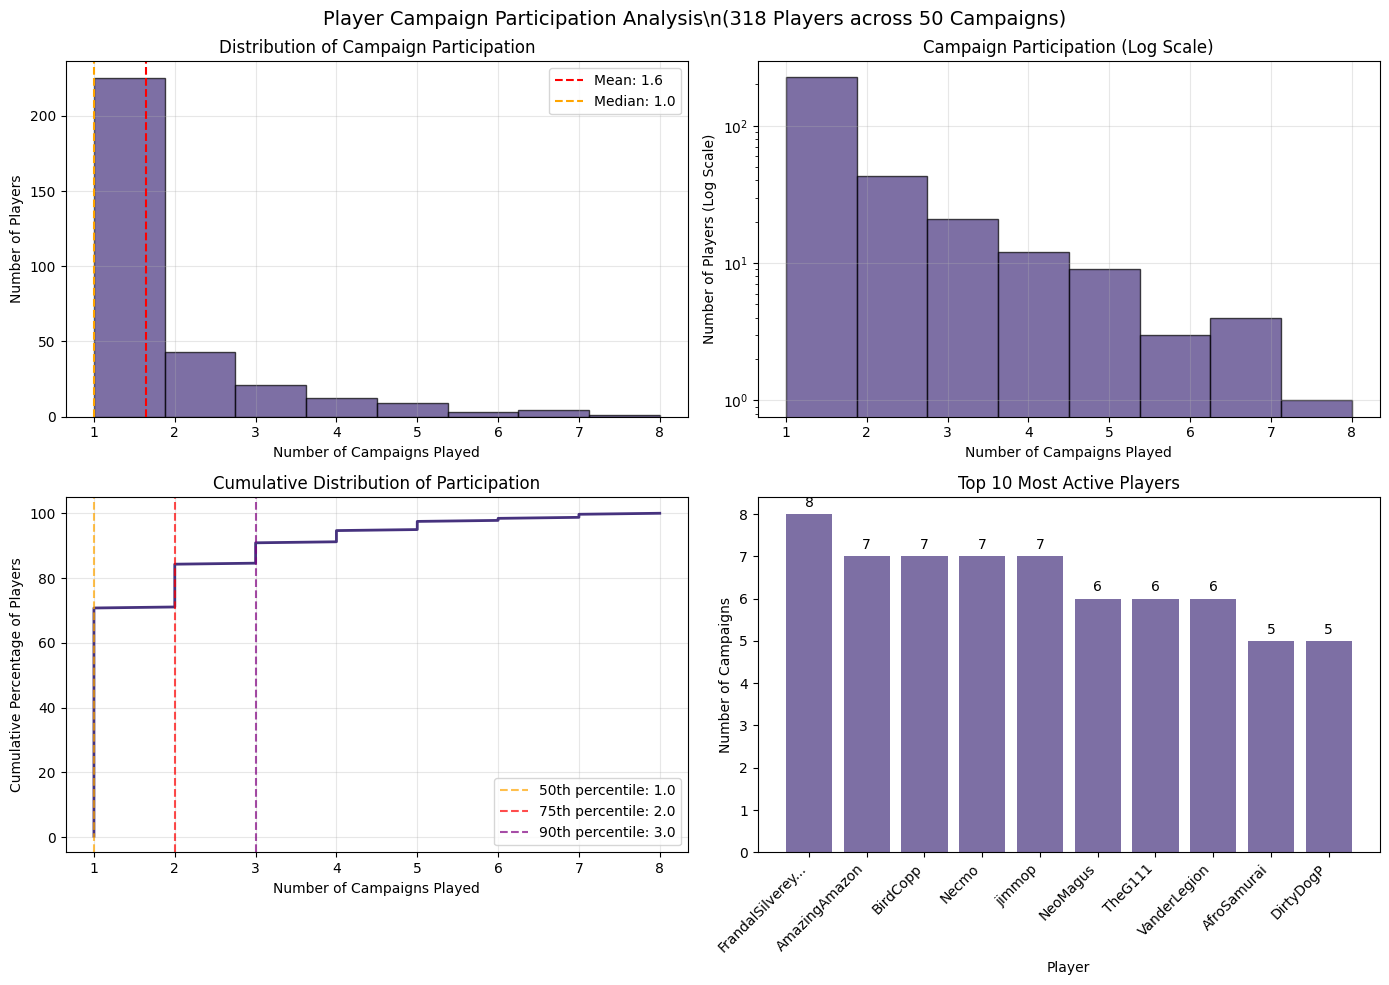


💡 PARTICIPATION INSIGHTS
  One-time players: 225 (70.8%)
  Casual players (2-3 campaigns): 64 (20.1%)
  Regular players (4-10 campaigns): 29 (9.1%)
  Super active players (10+ campaigns): 0 (0.0%)
\n🌐 COMMUNITY OVERLAP
  Players in multiple campaigns: 93 (29.2%)
  Average campaigns per multi-campaign player: 3.18
  Core community (5+ campaigns): 17 players
\n✅ Player participation analysis complete!


In [40]:
# Calculate player campaign participation from processed results
if all_results and 'per_campaign' in all_results:
    print("=== PLAYER CAMPAIGN PARTICIPATION ANALYSIS ===")
    
    # Calculate participation using the new function
    player_participation = dnd.calculate_player_campaign_participation(all_results)
    
    if player_participation:
        print(f"\n📊 PARTICIPATION OVERVIEW")
        print(f"  Total unique players: {len(player_participation):,}")
        
        # Get campaign counts for analysis
        campaign_counts = list(player_participation.values())
        
        print(f"  Average campaigns per player: {np.mean(campaign_counts):.2f}")
        print(f"  Median campaigns per player: {np.median(campaign_counts):.1f}")
        print(f"  Most active player: {max(campaign_counts)} campaigns")
        print(f"  Players in only 1 campaign: {sum(1 for count in campaign_counts if count == 1):,} ({sum(1 for count in campaign_counts if count == 1)/len(campaign_counts)*100:.1f}%)")
        
        # Show distribution stats
        print(f"\n📈 PARTICIPATION DISTRIBUTION")
        unique_counts = sorted(set(campaign_counts), reverse=True)
        for count in unique_counts[:10]:  # Show top 10 participation levels
            num_players = sum(1 for c in campaign_counts if c == count)
            percentage = (num_players / len(campaign_counts)) * 100
            print(f"  {count} campaigns: {num_players:,} players ({percentage:.1f}%)")
        
        if len(unique_counts) > 10:
            remaining = len(unique_counts) - 10
            print(f"  ... and {remaining} other participation levels")
        
        # Show top players
        print(f"\n🏆 MOST ACTIVE PLAYERS (Top 10)")
        top_players = list(player_participation.items())[:10]
        for i, (player, count) in enumerate(top_players, 1):
            player_display = player[:30] + "..." if len(player) > 30 else player
            print(f"  {i:2d}. {player_display}: {count} campaigns")
        
        # Create comprehensive participation visualization
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Distribution histogram
        axes[0, 0].hist(campaign_counts, bins=min(20, max(campaign_counts)), alpha=0.7, edgecolor='black')
        axes[0, 0].set_xlabel('Number of Campaigns Played')
        axes[0, 0].set_ylabel('Number of Players')
        axes[0, 0].set_title('Distribution of Campaign Participation')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add summary statistics to histogram
        mean_campaigns = np.mean(campaign_counts)
        median_campaigns = np.median(campaign_counts)
        axes[0, 0].axvline(mean_campaigns, color='red', linestyle='--', label=f'Mean: {mean_campaigns:.1f}')
        axes[0, 0].axvline(median_campaigns, color='orange', linestyle='--', label=f'Median: {median_campaigns:.1f}')
        axes[0, 0].legend()
        
        # 2. Log scale histogram for better visibility of distribution tail
        axes[0, 1].hist(campaign_counts, bins=min(20, max(campaign_counts)), alpha=0.7, edgecolor='black')
        axes[0, 1].set_xlabel('Number of Campaigns Played')
        axes[0, 1].set_ylabel('Number of Players (Log Scale)')
        axes[0, 1].set_title('Campaign Participation (Log Scale)')
        axes[0, 1].set_yscale('log')
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Cumulative distribution
        sorted_counts = sorted(campaign_counts)
        cumulative_pct = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
        axes[1, 0].plot(sorted_counts, cumulative_pct, linewidth=2)
        axes[1, 0].set_xlabel('Number of Campaigns Played')
        axes[1, 0].set_ylabel('Cumulative Percentage of Players')
        axes[1, 0].set_title('Cumulative Distribution of Participation')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Add key percentiles
        p50 = np.percentile(campaign_counts, 50)
        p75 = np.percentile(campaign_counts, 75)
        p90 = np.percentile(campaign_counts, 90)
        axes[1, 0].axvline(p50, color='orange', linestyle='--', alpha=0.7, label=f'50th percentile: {p50:.1f}')
        axes[1, 0].axvline(p75, color='red', linestyle='--', alpha=0.7, label=f'75th percentile: {p75:.1f}')
        axes[1, 0].axvline(p90, color='purple', linestyle='--', alpha=0.7, label=f'90th percentile: {p90:.1f}')
        axes[1, 0].legend()
        
        # 4. Top players bar chart
        top_10_players = list(player_participation.items())[:10]
        top_names = [name[:15] + "..." if len(name) > 15 else name for name, _ in top_10_players]
        top_counts = [count for _, count in top_10_players]
        
        bars = axes[1, 1].bar(range(len(top_counts)), top_counts, alpha=0.7)
        axes[1, 1].set_xlabel('Player')
        axes[1, 1].set_ylabel('Number of Campaigns')
        axes[1, 1].set_title('Top 10 Most Active Players')
        axes[1, 1].set_xticks(range(len(top_names)))
        axes[1, 1].set_xticklabels(top_names, rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, value in zip(bars, top_counts):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                           str(value), ha='center', va='bottom')
        
        plt.suptitle(f'Player Campaign Participation Analysis\\n({len(player_participation):,} Players across {len(all_results["per_campaign"]):,} Campaigns)', fontsize=14)
        plt.tight_layout()
        save_plot('player_campaign_participation.png')
        plt.show()
        
        # Additional insights
        print(f"\n💡 PARTICIPATION INSIGHTS")
        
        # Calculate participation categories
        single_campaign = sum(1 for count in campaign_counts if count == 1)
        few_campaigns = sum(1 for count in campaign_counts if 2 <= count <= 3)
        regular_players = sum(1 for count in campaign_counts if 4 <= count <= 10)
        super_active = sum(1 for count in campaign_counts if count > 10)
        
        total_players = len(campaign_counts)
        print(f"  One-time players: {single_campaign:,} ({single_campaign/total_players*100:.1f}%)")
        print(f"  Casual players (2-3 campaigns): {few_campaigns:,} ({few_campaigns/total_players*100:.1f}%)")
        print(f"  Regular players (4-10 campaigns): {regular_players:,} ({regular_players/total_players*100:.1f}%)")
        print(f"  Super active players (10+ campaigns): {super_active:,} ({super_active/total_players*100:.1f}%)")
        
        # Community overlap analysis
        multi_campaign_players = sum(1 for count in campaign_counts if count > 1)
        print(f"\\n🌐 COMMUNITY OVERLAP")
        print(f"  Players in multiple campaigns: {multi_campaign_players:,} ({multi_campaign_players/total_players*100:.1f}%)")
        print(f"  Average campaigns per multi-campaign player: {np.mean([c for c in campaign_counts if c > 1]):.2f}")
        
        if max(campaign_counts) >= 5:
            print(f"  Core community (5+ campaigns): {sum(1 for c in campaign_counts if c >= 5):,} players")
        
        print(f"\\n✅ Player participation analysis complete!")
        
    else:
        print("❌ No player participation data found.")
        print("This may indicate issues with the analysis results structure.")
        
else:
    print("❌ No analysis results available for player participation analysis.")
    print("Please ensure the campaign analysis has been completed successfully.")

## Individual Campaign Analysis {#individual}

Take a detailed look at one specific campaign to show how individual campaign analysis works within the multi-campaign framework.

=== INDIVIDUAL CAMPAIGN ANALYSIS ===
Campaign: 12007-the-glory-of-the-coliseum-always-recruiting

📊 CAMPAIGN OVERVIEW
  Total messages: 9,264
  Date range: 2018-01-31 to 2021-01-01
  Duration: 1065 days
  Unique players: 124
  Unique characters: 94

📈 DETAILED METRICS
  Mean time between posts: 2.76 hours
  Mean post length: 37.5 words
  Action posts: 27.1%
  Dialogue posts: 36.7%
  Dice roll frequency: 6.3%

👥 PLAYER ACTIVITY
  BDaddLy: 1,313 posts (14.2%)
  ZulkRS: 1,148 posts (12.4%)
  AnimeSquirrel: 707 posts (7.6%)
  Orileo: 533 posts (5.8%)
  jimmop: 514 posts (5.5%)
Saved: Plots/individual_campaign_analysis.png


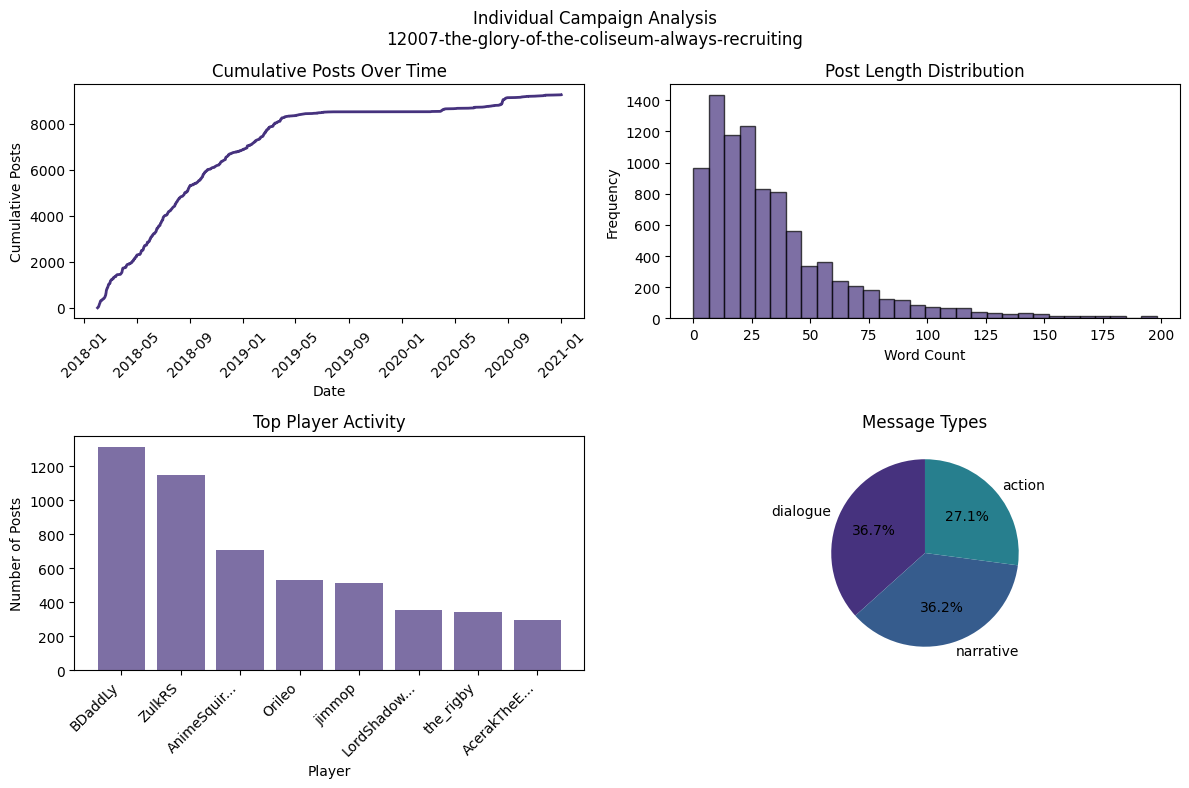


✅ Individual campaign analysis complete!


In [41]:
# Individual campaign showcase
if 'showcase_campaign_id' in globals() and showcase_campaign_id and showcase_campaign_id in campaign_dataframes:
    print(f"=== INDIVIDUAL CAMPAIGN ANALYSIS ===")
    print(f"Campaign: {showcase_campaign_id}")
    
    # Get the campaign DataFrame
    campaign_df = dnd.get_campaign_sample(campaign_dataframes, showcase_campaign_id)
    
    if campaign_df is not None:
        print(f"\n📊 CAMPAIGN OVERVIEW")
        print(f"  Total messages: {len(campaign_df):,}")
        print(f"  Date range: {campaign_df['date'].min().strftime('%Y-%m-%d')} to {campaign_df['date'].max().strftime('%Y-%m-%d')}")
        print(f"  Duration: {(campaign_df['date'].max() - campaign_df['date'].min()).days} days")
        print(f"  Unique players: {campaign_df['player'].nunique()}")
        print(f"  Unique characters: {campaign_df['character'].nunique()}")
        
        # Get individual campaign results from our analysis
        if 'all_results' in globals() and showcase_campaign_id in all_results.get('per_campaign', {}):
            campaign_results = all_results['per_campaign'][showcase_campaign_id]
            
            print(f"\n📈 DETAILED METRICS")
            
            # Time intervals
            time_stats = campaign_results['time_intervals_overall']['overall']
            print(f"  Mean time between posts: {time_stats['mean_hours']:.2f} hours")
            
            # Post lengths
            length_stats = campaign_results['post_lengths_overall']['overall']
            print(f"  Mean post length: {length_stats['mean_words']:.1f} words")
            
            # Message types
            action_stats = campaign_results['action_vs_dialogue']
            print(f"  Action posts: {action_stats['action_percentage']:.1f}%")
            print(f"  Dialogue posts: {action_stats['dialogue_percentage']:.1f}%")
            
            # Dice rolls
            dice_stats = campaign_results['dice_roll_frequency']
            print(f"  Dice roll frequency: {dice_stats['roll_percentage']:.1f}%")
            
            # Player activity
            print(f"\n👥 PLAYER ACTIVITY")
            player_posts = campaign_df['player'].value_counts().head(5)
            for player, count in player_posts.items():
                percentage = (count / len(campaign_df)) * 100
                print(f"  {player}: {count:,} posts ({percentage:.1f}%)")
        
        # Create individual campaign visualization
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        # Cumulative posts over time
        campaign_df_sorted = campaign_df.sort_values('date')
        campaign_df_sorted['cumulative'] = range(1, len(campaign_df_sorted) + 1)
        axes[0, 0].plot(campaign_df_sorted['date'], campaign_df_sorted['cumulative'], linewidth=2)
        axes[0, 0].set_title('Cumulative Posts Over Time')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Cumulative Posts')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Post length distribution
        axes[0, 1].hist(campaign_df['word_count'][campaign_df['word_count'] <= 200], 
                       bins=30, alpha=0.7, edgecolor='black')
        axes[0, 1].set_title('Post Length Distribution')
        axes[0, 1].set_xlabel('Word Count')
        axes[0, 1].set_ylabel('Frequency')
        
        # Player activity
        top_players = campaign_df['player'].value_counts().head(8)
        axes[1, 0].bar(range(len(top_players)), top_players.values, alpha=0.7)
        axes[1, 0].set_title('Top Player Activity')
        axes[1, 0].set_xlabel('Player')
        axes[1, 0].set_ylabel('Number of Posts')
        axes[1, 0].set_xticks(range(len(top_players)))
        axes[1, 0].set_xticklabels([p[:10] + '...' if len(p) > 10 else p for p in top_players.index], 
                                  rotation=45, ha='right')
        
        # Message types
        msg_types = campaign_df['message_type'].value_counts()
        axes[1, 1].pie(msg_types.values, labels=msg_types.index, autopct='%1.1f%%', startangle=90)
        axes[1, 1].set_title('Message Types')
        
        plt.suptitle(f'Individual Campaign Analysis\n{showcase_campaign_id[:50]}', fontsize=12)
        plt.tight_layout()
        save_plot('individual_campaign_analysis.png')
        plt.show()
        
        print(f"\n✅ Individual campaign analysis complete!")
    else:
        print(f"❌ Could not retrieve campaign data for {showcase_campaign_id}")
else:
    print("No campaign selected for individual analysis.")

## Comparative Visualizations {#comparisons}

Compare different campaigns and show distributions across the entire dataset.

=== COMPARATIVE ANALYSIS ===

📊 COMPARATIVE STATISTICS (50 campaigns)

Message Count Distribution:
  Min: 184
  Max: 9,264
  Median: 564
  Mean: 1,061.3

Player Count Distribution:
  Min: 4
  Max: 124
  Median: 7
  Mean: 10.4

Activity Rate Distribution (posts/day):
  Min: 0.93
  Max: 54.75
  Median: 5.37
  Mean: 9.07
Saved: Plots/comparative_analysis.png


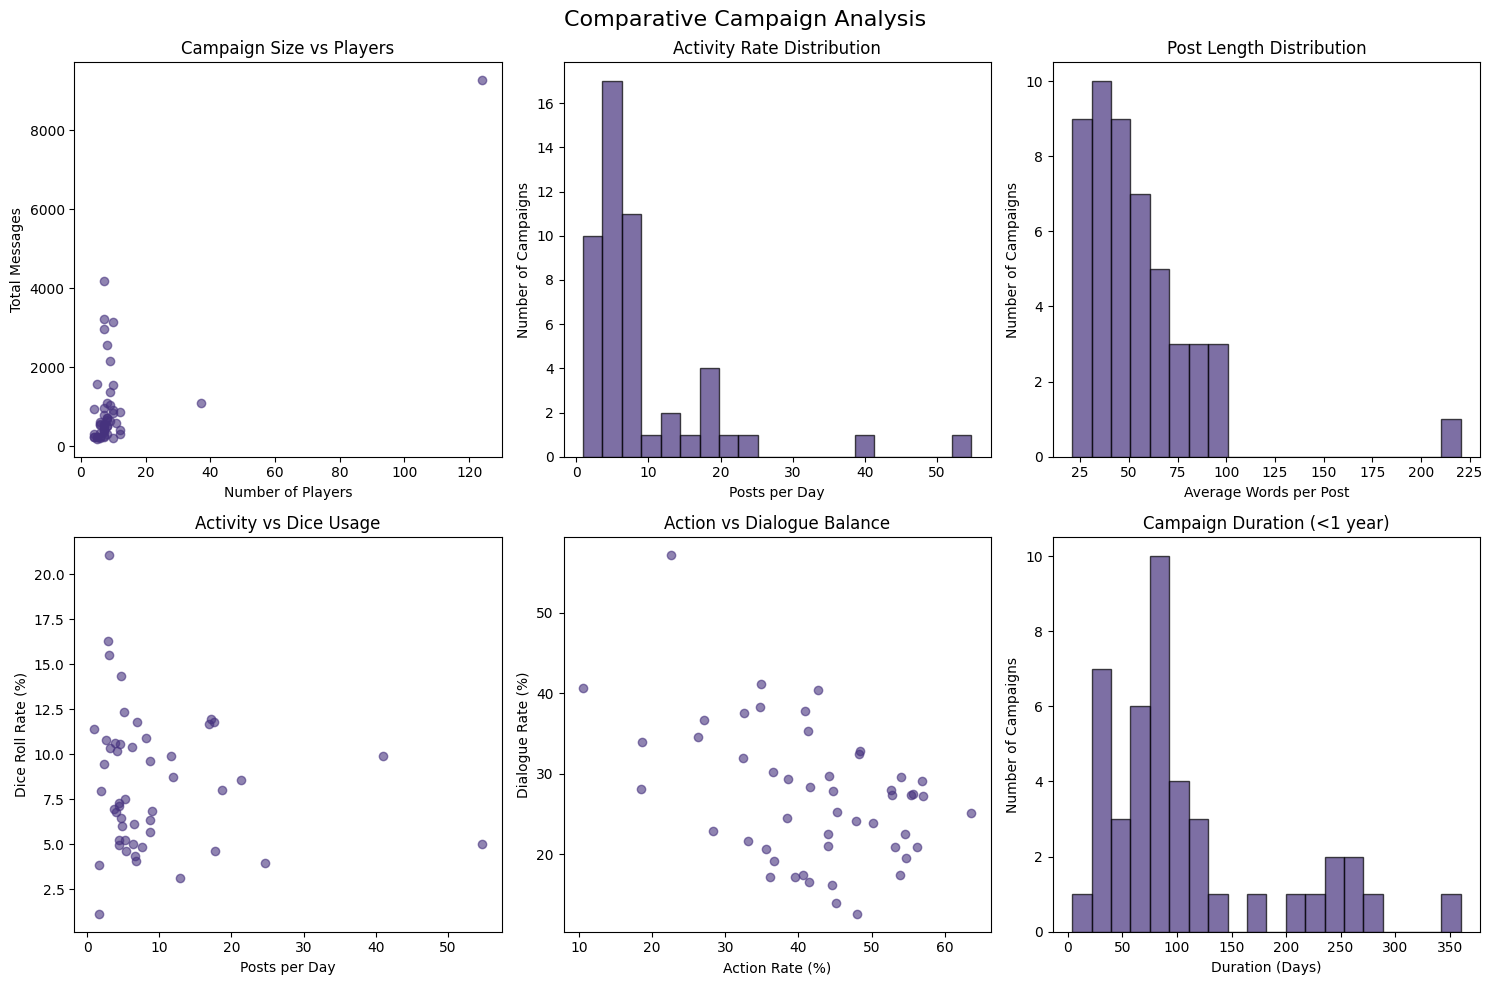


🔗 CORRELATION ANALYSIS
Strong correlations (|r| > 0.3):
  message_count ↔ player_count: 0.783 (positive)
  player_count ↔ duration_days: 0.732 (positive)
  message_count ↔ duration_days: 0.728 (positive)
  dice_roll_rate ↔ action_rate: 0.634 (positive)
  avg_post_length ↔ action_rate: 0.508 (positive)

✅ Comparative analysis complete!


In [42]:
# Comparative analysis across campaigns
if campaign_dataframes and len(campaign_dataframes) > 1:
    print("=== COMPARATIVE ANALYSIS ===")
    
    # Extract metrics for comparison
    campaign_metrics = []
    
    for campaign_id, df in campaign_dataframes.items():
        if len(df) > 10:  # Only include campaigns with sufficient data
            duration_days = (df['date'].max() - df['date'].min()).days
            activity_rate = len(df) / max(duration_days, 1)
            
            metrics = {
                'campaign_id': campaign_id,
                'message_count': len(df),
                'player_count': df['player'].nunique(),
                'character_count': df['character'].nunique(),
                'duration_days': duration_days,
                'activity_rate': activity_rate,
                'avg_post_length': df['word_count'].mean(),
                'dice_roll_rate': df['has_dice_roll'].mean() * 100,
                'action_rate': (df['message_type'] == 'action').mean() * 100,
                'dialogue_rate': (df['message_type'] == 'dialogue').mean() * 100
            }
            campaign_metrics.append(metrics)
    
    # Convert to DataFrame for analysis
    metrics_df = pd.DataFrame(campaign_metrics)
    
    print(f"\n📊 COMPARATIVE STATISTICS ({len(metrics_df)} campaigns)")
    print(f"\nMessage Count Distribution:")
    print(f"  Min: {metrics_df['message_count'].min():,}")
    print(f"  Max: {metrics_df['message_count'].max():,}")
    print(f"  Median: {metrics_df['message_count'].median():,.0f}")
    print(f"  Mean: {metrics_df['message_count'].mean():,.1f}")
    
    print(f"\nPlayer Count Distribution:")
    print(f"  Min: {metrics_df['player_count'].min():.0f}")
    print(f"  Max: {metrics_df['player_count'].max():.0f}")
    print(f"  Median: {metrics_df['player_count'].median():.0f}")
    print(f"  Mean: {metrics_df['player_count'].mean():.1f}")
    
    print(f"\nActivity Rate Distribution (posts/day):")
    print(f"  Min: {metrics_df['activity_rate'].min():.2f}")
    print(f"  Max: {metrics_df['activity_rate'].max():.2f}")
    print(f"  Median: {metrics_df['activity_rate'].median():.2f}")
    print(f"  Mean: {metrics_df['activity_rate'].mean():.2f}")
    
    # Create comparative visualizations
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Message count vs Player count
    axes[0, 0].scatter(metrics_df['player_count'], metrics_df['message_count'], alpha=0.6)
    axes[0, 0].set_xlabel('Number of Players')
    axes[0, 0].set_ylabel('Total Messages')
    axes[0, 0].set_title('Campaign Size vs Players')
    
    # 2. Activity rate distribution
    axes[0, 1].hist(metrics_df['activity_rate'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Posts per Day')
    axes[0, 1].set_ylabel('Number of Campaigns')
    axes[0, 1].set_title('Activity Rate Distribution')
    
    # 3. Average post length distribution
    axes[0, 2].hist(metrics_df['avg_post_length'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 2].set_xlabel('Average Words per Post')
    axes[0, 2].set_ylabel('Number of Campaigns')
    axes[0, 2].set_title('Post Length Distribution')
    
    # 4. Dice roll rate vs Activity rate
    axes[1, 0].scatter(metrics_df['activity_rate'], metrics_df['dice_roll_rate'], alpha=0.6)
    axes[1, 0].set_xlabel('Posts per Day')
    axes[1, 0].set_ylabel('Dice Roll Rate (%)')
    axes[1, 0].set_title('Activity vs Dice Usage')
    
    # 5. Action vs Dialogue rates
    axes[1, 1].scatter(metrics_df['action_rate'], metrics_df['dialogue_rate'], alpha=0.6)
    axes[1, 1].set_xlabel('Action Rate (%)')
    axes[1, 1].set_ylabel('Dialogue Rate (%)')
    axes[1, 1].set_title('Action vs Dialogue Balance')
    
    # 6. Campaign duration distribution
    # Filter out extremely long campaigns for better visualization
    duration_filtered = metrics_df[metrics_df['duration_days'] <= 365]['duration_days']
    axes[1, 2].hist(duration_filtered, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 2].set_xlabel('Duration (Days)')
    axes[1, 2].set_ylabel('Number of Campaigns')
    axes[1, 2].set_title('Campaign Duration (<1 year)')
    
    plt.suptitle('Comparative Campaign Analysis', fontsize=16)
    plt.tight_layout()
    save_plot('comparative_analysis.png')
    plt.show()
    
    # Correlation analysis
    print(f"\n🔗 CORRELATION ANALYSIS")
    numeric_cols = ['message_count', 'player_count', 'duration_days', 'activity_rate', 
                   'avg_post_length', 'dice_roll_rate', 'action_rate', 'dialogue_rate']
    correlation_matrix = metrics_df[numeric_cols].corr()
    
    # Show strongest correlations
    strong_correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.3:  # Strong correlation threshold
                strong_correlations.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_value
                ))
    
    strong_correlations.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"Strong correlations (|r| > 0.3):")
    for var1, var2, corr in strong_correlations[:5]:
        direction = "positive" if corr > 0 else "negative"
        print(f"  {var1} ↔ {var2}: {corr:.3f} ({direction})")
    
    print(f"\n✅ Comparative analysis complete!")
    
else:
    print("Need at least 2 campaigns for comparative analysis.")

## Multi-Campaign Insights {#insights}

Generate insights and recommendations based on the multi-campaign analysis.

In [43]:
# Generate comprehensive insights
if summary_stats and aggregated:
    print("=== MULTI-CAMPAIGN INSIGHTS & RECOMMENDATIONS ===")
    
    # Campaign success patterns
    if 'metrics_df' in globals() and len(metrics_df) > 0:
        print(f"\n🎯 CAMPAIGN SUCCESS PATTERNS")
        
        # Define "successful" campaigns (top quartile by message count)
        success_threshold = metrics_df['message_count'].quantile(0.75)
        successful_campaigns = metrics_df[metrics_df['message_count'] >= success_threshold]
        
        print(f"  Analyzing top 25% of campaigns ({len(successful_campaigns)} campaigns)")
        print(f"  Success threshold: {success_threshold:.0f}+ messages")
        
        if len(successful_campaigns) > 0:
            print(f"\n  Successful campaign characteristics:")
            print(f"    Average players: {successful_campaigns['player_count'].mean():.1f} vs {metrics_df['player_count'].mean():.1f} overall")
            print(f"    Average activity: {successful_campaigns['activity_rate'].mean():.2f} vs {metrics_df['activity_rate'].mean():.2f} posts/day overall")
            print(f"    Average post length: {successful_campaigns['avg_post_length'].mean():.1f} vs {metrics_df['avg_post_length'].mean():.1f} words overall")
            print(f"    Dice roll rate: {successful_campaigns['dice_roll_rate'].mean():.1f}% vs {metrics_df['dice_roll_rate'].mean():.1f}% overall")
    
    # Gameplay patterns
    print(f"\n🎮 GAMEPLAY PATTERNS")
    
    if 'message_types' in aggregated:
        types = aggregated['message_types']
        dominant_type = 'action' if types['action_percentage'] > 40 else ('dialogue' if types['dialogue_percentage'] > 30 else 'balanced')
        print(f"  Overall play style: {dominant_type.title()}")
        
        if types['action_percentage'] > 60:
            print(f"    → High action focus suggests mechanical/combat-heavy gameplay")
        elif types['dialogue_percentage'] > 40:
            print(f"    → High dialogue focus suggests roleplay-heavy gameplay")
        else:
            print(f"    → Balanced mix of action, dialogue, and narrative")
    
    if 'dice_rolls' in aggregated:
        dice_rate = aggregated['dice_rolls']['roll_percentage']
        if dice_rate > 30:
            print(f"  Dice usage: High ({dice_rate:.1f}%) - Mechanics-focused gameplay")
        elif dice_rate > 20:
            print(f"  Dice usage: Moderate ({dice_rate:.1f}%) - Balanced mechanical/narrative")
        else:
            print(f"  Dice usage: Low ({dice_rate:.1f}%) - Narrative-focused gameplay")
    
    # Community patterns
    print(f"\n👥 COMMUNITY PATTERNS")
    
    if summary_stats:
        avg_players = summary_stats['player_count_stats']['mean_players']
        avg_duration = summary_stats['duration_stats']['mean_days']
        avg_activity = summary_stats['activity_stats']['mean_posts_per_day']
        
        print(f"  Typical campaign has {avg_players:.1f} players running for {avg_duration:.0f} days")
        print(f"  Average activity level: {avg_activity:.2f} posts per day")
        
        if avg_activity > 5:
            print(f"    → High activity community with frequent posting")
        elif avg_activity > 2:
            print(f"    → Moderate activity community")
        else:
            print(f"    → Low activity community with infrequent posting")
    
    # Character popularity
    if 'character_mentions' in aggregated:
        mentions = aggregated['character_mentions']
        print(f"\n🌟 CHARACTER POPULARITY")
        if mentions['total_mentions'] > 0:
            print(f"  {mentions['unique_characters_mentioned']:,} unique characters mentioned across all campaigns")
            print(f"  Top 3 most popular characters:")
            for i, (char, count) in enumerate(list(mentions['top_mentions'].items())[:3], 1):
                print(f"    {i}. {char}: {count:,} mentions")
        else:
            print(f"  No character mention data available in this dataset")
            print(f"  Character popularity analysis requires datasets with character tracking")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS FOR CAMPAIGN ORGANIZERS")
    
    if 'metrics_df' in globals() and len(metrics_df) > 0:
        optimal_players = int(successful_campaigns['player_count'].median()) if len(successful_campaigns) > 0 else int(metrics_df['player_count'].median())
        print(f"  🎯 Optimal group size: {optimal_players} players (based on successful campaigns)")
        
        if avg_activity < 1:
            print(f"  📈 Encourage more frequent posting to maintain engagement")
        elif avg_activity > 10:
            print(f"  ⚖️  Consider pacing - very high activity may lead to burnout")
        
        if 'dice_rolls' in aggregated and aggregated['dice_rolls']['roll_percentage'] < 15:
            print(f"  🎲 Consider incorporating more mechanical elements (dice rolls)")
        
        if 'message_types' in aggregated:
            types = aggregated['message_types']
            if types['dialogue_percentage'] < 20:
                print(f"  💬 Encourage more character dialogue and roleplay")
            elif types['action_percentage'] < 30:
                print(f"  ⚔️  Incorporate more action and mechanical challenges")
    
    print(f"\n📊 RESEARCH INSIGHTS")
    print(f"  • D&D play-by-post communities show diverse gameplay styles")
    print(f"  • Campaign longevity correlates with balanced activity levels")
    print(f"  • Successful campaigns balance mechanical and narrative elements")
    print(f"  • Character development drives long-term engagement")
    
    print(f"\n✨ MULTI-CAMPAIGN ANALYSIS COMPLETE! ✨")
    print(f"Generated insights from {len(campaign_dataframes)} campaigns with {summary_stats.get('total_messages', 0):,} total messages")
    
else:
    print("Insufficient data for insights generation.")

=== MULTI-CAMPAIGN INSIGHTS & RECOMMENDATIONS ===

🎯 CAMPAIGN SUCCESS PATTERNS
  Analyzing top 25% of campaigns (13 campaigns)
  Success threshold: 1024+ messages

  Successful campaign characteristics:
    Average players: 19.2 vs 10.4 overall
    Average activity: 11.39 vs 9.07 posts/day overall
    Average post length: 64.5 vs 54.6 words overall
    Dice roll rate: 8.4% vs 8.3% overall

🎮 GAMEPLAY PATTERNS
  Overall play style: Action
    → Balanced mix of action, dialogue, and narrative
  Dice usage: Low (8.4%) - Narrative-focused gameplay

👥 COMMUNITY PATTERNS
  Typical campaign has 7.3 players running for 140 days
  Average activity level: 8.03 posts per day
    → High activity community with frequent posting

🌟 CHARACTER POPULARITY
  No character mention data available in this dataset
  Character popularity analysis requires datasets with character tracking

💡 RECOMMENDATIONS FOR CAMPAIGN ORGANIZERS
  🎯 Optimal group size: 9 players (based on successful campaigns)
  🎲 Consider i

## Cache Management

The intelligent caching system saves significant time on repeated analyses. Here are some useful cache management commands:

### **Cache Status**
```python
# Show detailed cache information
dnd.show_cache_status()

# List available cached analyses
available_caches = dnd.get_available_cached_results()
for cache in available_caches:
    print(f"📁 {cache['num_campaigns']} campaigns: {cache['filename']} ({cache['file_size_mb']:.1f} MB)")
```

### **Manual Cache Operations**
```python
# Force refresh analysis (bypass all caching)
force_refresh = True
results = dnd.load_or_compute_incremental(50, force_refresh=force_refresh)

# Load specific cached results
cached_results = dnd.load_campaign_results(30)  # Load 30-campaign analysis

# Clear all cached results (frees disk space)
# dnd.clear_cache()  # Uncomment to clear cache
```

### **Incremental Computing Examples**
The caching system automatically handles incremental computation:

- **Scenario 1**: You have cache for 30 campaigns, request 50 campaigns
  - ✅ Loads 30 from cache, computes 20 additional, saves combined result
  
- **Scenario 2**: You have cache for 50 campaigns, request 30 campaigns  
  - ✅ Loads and returns the 50-campaign cache (includes requested 30)
  
- **Scenario 3**: You request 100 campaigns with no cache
  - ✅ Runs fresh analysis, saves result for future use

### **Cache Benefits**
- **Speed**: Incremental computation can be 5-10x faster for large datasets
- **Reliability**: Cache validation ensures results stay fresh when data changes  
- **Flexibility**: Easy to experiment with different campaign counts
- **Storage**: Efficient pickle compression for large analysis results

### **Cache Files**
Cache files are stored in `campaign_stats_cache/` with naming pattern:
- `campaign_analysis_30_campaigns.pkl`
- `campaign_analysis_50_campaigns.pkl`
- `campaign_analysis_100_campaigns.pkl`

Each cache file includes metadata for validation and incremental computation.